# Lab 6: PCA

## Data 88 - Data Science in Genetics and Genomics, 10/29/19

## by Jonathan Fischer

Last week we talked about principal component analysis (PCA), a ubiquitous statistical technique used in EDA, data visualization, dimension reduction, and data pre-processing. Today we'll build on that and our previous exposure to this method. If you want a refresher, the top answer to this question provides a lovely exposition: https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues.

In [1]:
# Load the modules we'll need
from datascience import *
import numpy as np
import random
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.stats as stats
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_spd_matrix
plt.style.use('fivethirtyeight')

PCA finds a good way to summarize your data using fewer dimensions than you started with. The covariance (aka the "shape") of your data dictates how easily it can do this. Data with highly correlated features has many redundancies and can thus be represented by fewer dimensions more easily. We can see this directly be considering data with different covariances.

### PCA on "spherical" data

First we'll consider data in which each dimension is statistically independent from the others. This data will have a spherical shape and should be difficult to represent well using fewer dimensions. We'll consider data with 5 dimensions.

In [2]:
# Randomly sample the means for each dimension. These dimensions are often called features
sphere_means = list(np.random.normal(0, 1, 5))

# Draw a sample of 5000 points with the appropriate means and covariance
x_sphere = np.random.multivariate_normal(sphere_means, np.identity(5), 5000)

We touched briefly on the fact that standardization of our data is often a necessary step of PCA. This helps in a couple of ways. First, it removes the mean which could potentially dominate our signal (see this post https://stats.stackexchange.com/questions/22329/how-does-centering-the-data-get-rid-of-the-intercept-in-regression-and-pca). Subtraction of the mean is called "centering" our data. Second, it puts all variables on the same scale such that quantities with naturally higher variances don't dominate (this is "scaling"). Depending on your data, the scaling step may or may not be a good idea. It's a bit of an art and knowing what to do will come with experience. For now we'll go ahead and scale. This link (https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html) shows what can happen if we don't scale.

In [3]:
# Compute the sample mean and standard deviation of each feature. 
# We then use these to standardize our features. If you've seen z-scores before, this should feel familiar.
sphere_means = np.mean(x_sphere, axis = 0)
sphere_sds = np.std(x_sphere, axis = 0)

y_sphere = (x_sphere - sphere_means) / sphere_sds

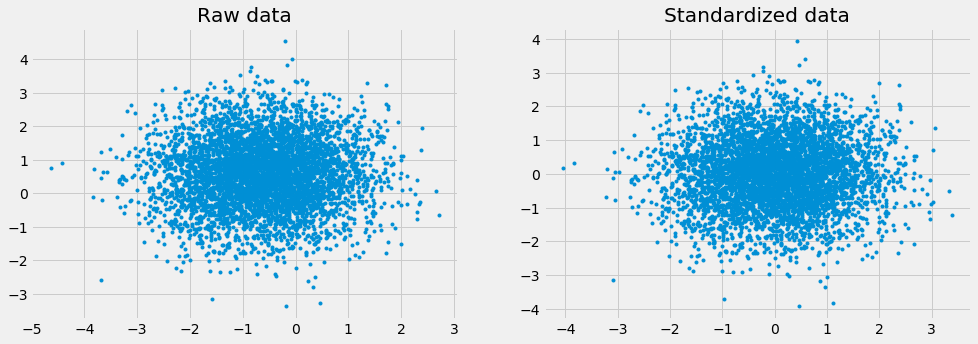

In [4]:
# Let's look at what standardization does to our data. 
# In this case it probably won't do too much since the means are small and the variances were all 1.
# Feel free to play around with the means and variances to see whether it plays a difference.

# Choose which features to look at (0,1,2,3,4)
i = 0
j = 1

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(x_sphere[:,i], x_sphere[:,j], '.')
plt.title('Raw data')

plt.subplot(122)
plt.plot(y_sphere[:,i], y_sphere[:,j], '.')
plt.title('Standardized data')

plt.show()

In [5]:
# Let's perform PCA on our standardized data. 
# In Python, you first create a PCA object by specifying how many components to estimate.
# This number of components cannot exceed the original dimensionality of your data. In fact,
# it cannot be greater than min(n_dim, n_obs) for reasons related to linear algebra (rank).
pca_sphere = PCA(n_components=5)
pca_sphere.fit(y_sphere.T)  

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [6]:
# The byproduct of PCA are the coordinates of our data in the new set of features. These features are assembled by 
# taking combinations of our original ones.
sphere_comps = pca_sphere.components_

Now let's look at how our data behave in the new coordinate system. We can also look at the singular values, which represent the strength of each component. You can think of these as the lengths of the axes of an ellipse which enclose our data. By plotting these, we get a sense of how many dimensions are needed to represent our data. Related is the percent of variance explained. This tells us how much of our original signal gets captured by the particular component associated with that singular value. How does the plot look in this case?

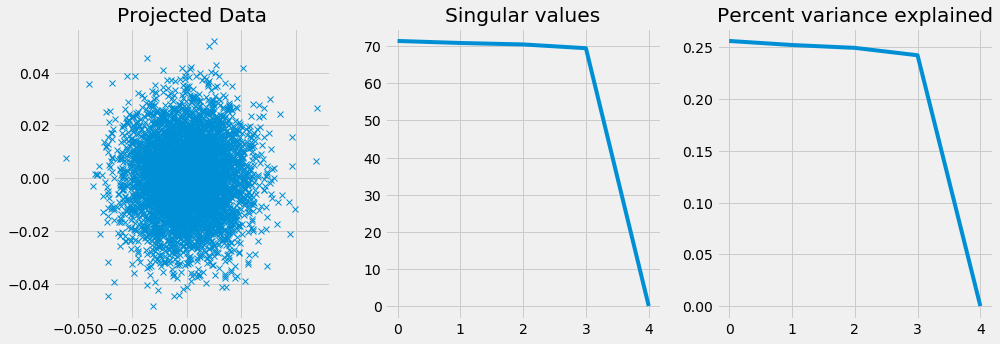

In [7]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(sphere_comps[0,:], sphere_comps[1,:], 'x')
plt.title('Projected Data')

plt.subplot(132)
plt.plot(pca_sphere.singular_values_)
plt.title('Singular values')

plt.subplot(133)
plt.plot(pca_sphere.explained_variance_ratio_)
plt.title('Percent variance explained')

plt.show()

Another feature of PCA is that the new variables are linearly independent. You can think of this as meaning these new directions are perpendicular to one another. Mathematically, we can see this by looking at the so-called dot product of any two components; if the value is 0, these two vectors are "orthogonal" (perpendicular).

In [8]:
# Try it for any pair below. Also note that the dot product is identical to taking the element-wise product and 
# then summing the values (up to minor numerical fluctuations)
print(np.dot(sphere_comps[0,:], sphere_comps[1,:]), np.sum(sphere_comps[0,:] * sphere_comps[1,:]))

-4.336808689942018e-17 -3.642919299551295e-17


### PCA on ellipsoid data

Now that we've seen an example where dimension reduction is hard, let's look at one where there is a fair amount of correlation between the features. You can see this below in the covariance matrix, which has a bit of a block structure. In some sense, this data can be reasonably approximated as two-dimensional despite actually having 5.

In [9]:
# Sample means with the specified covariance matrix.
ellipse_means = list(np.random.normal(0, 1, 5))
ellipse_cov = [[1,.8,0,0,0],
      [.8,1,0,0,0],
      [0,0,1,.8,.8],
      [0,0,.8,1,.8],
      [0,0,.8,.8,1]]

# Draw and standardize your observations.
x_ellipse = np.random.multivariate_normal(ellipse_means, ellipse_cov, 5000) # fill in the correct means and covariance matrix (the ones from above)

# Compute the mean of each feature and the standard deviation
ellipse_means = np.mean(x_ellipse, axis = 0)
ellipse_sds = np.std(x_ellipse, axis = 0)

# Standardize your data
y_ellipse = (x_ellipse - ellipse_means) / ellipse_sds

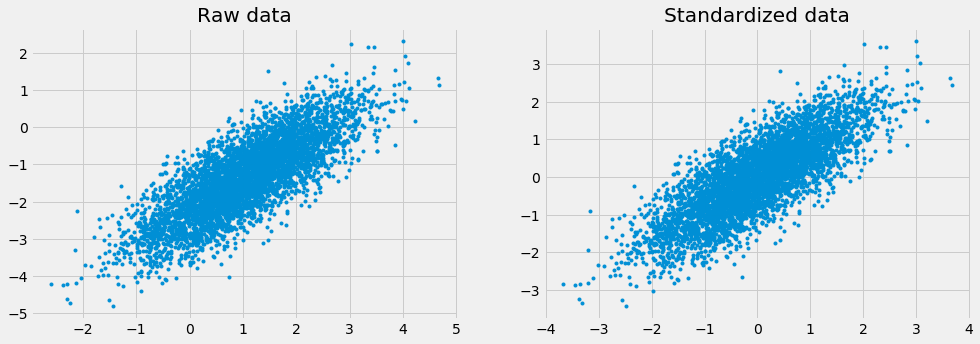

In [11]:
# Plot the raw and standardized data for any two chosen dimensions. Note the shape is much different from before.
# Play around with different values of i and j and note what happens.
i = 0
j = 1

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(x_ellipse[:,i], x_ellipse[:,j], '.')
plt.title('Raw data')

plt.subplot(122)
plt.plot(y_ellipse[:,i], y_ellipse[:,j], '.')
plt.title('Standardized data')

plt.show()

In [11]:
# Do PCA on the standardized data
pca_ellipse = PCA(n_components=5)
pca_ellipse.fit(y_ellipse.T)  
ellipse_comps = pca_ellipse.components_

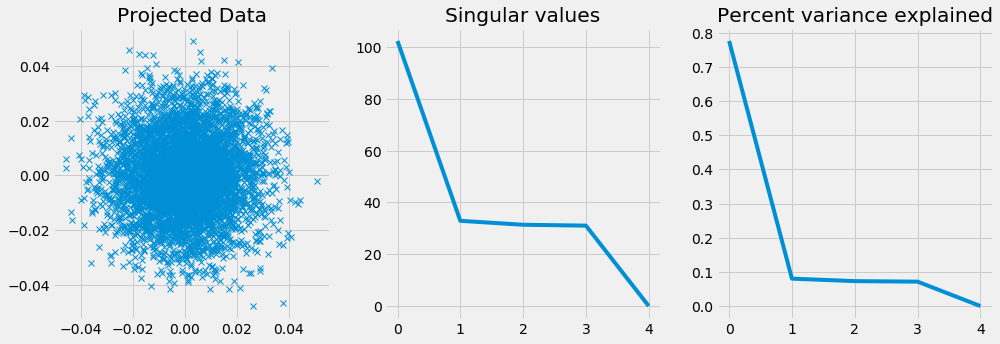

In [12]:
# Produce the plots of the projected data, singular values, and variance explained. 
# Note the similarities and differences between this and the spherical data.

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(ellipse_comps[0,:], ellipse_comps[1,:], 'x')
plt.title('Projected Data')

plt.subplot(132)
plt.plot(pca_ellipse.singular_values_)
plt.title('Singular values')

plt.subplot(133)
plt.plot(pca_ellipse.explained_variance_ratio_)
plt.title('Percent variance explained')

plt.show()

In [13]:
# Should be basically zero again
np.dot(ellipse_comps[0,:], ellipse_comps[1,:])

4.5102810375396984e-17

### PCA for clustering

You may have noticed that the projections didn't seem very informative in either of the two cases we've considered. This is because all of the data were drawn from the same distribution, so we wouldn't expect PCA to separate any of the points. However, one of the primary uses of PCA is identifying clusters of points that may be lurking in high-dimensional data. To investigate this ability, we'll consider data which contain points from multiple different distributions. 

In [14]:
# Draw the mean and covariance matrices. Don't worry too much about this step if you're unfamiliar with
# covariance matrices (and positive semidefinite matrices). 
# The important thing to note is that we have 4 clusters of points.

means1 = list(np.random.normal(0, 5, 5))
means2 = list(np.random.normal(0, 5, 5))
means3 = list(np.random.normal(0, 5, 5))
means4 = list(np.random.normal(0, 5, 5))

cov_mat1 = make_spd_matrix(5, random_state=1)
cov_mat2 = make_spd_matrix(5, random_state=2)
cov_mat3 = make_spd_matrix(5, random_state=3)
cov_mat4 = make_spd_matrix(5, random_state=4)

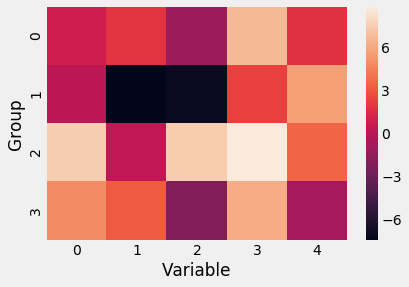

In [15]:
# Let's merge our means together and look at a visual representation. 
# Which features do we expect to well-separate our points?
cluster_means = np.concatenate(([means1], [means2], [means3], [means4]))
means_heatmap = sns.heatmap(cluster_means)
plt.xlabel('Variable')
plt.ylabel('Group')
plt.show()

In [16]:
# Now let's sample points from each cluster and put them together into a single set of observations.
x1 = np.random.multivariate_normal(means1, cov_mat1, 1500)
x2 = np.random.multivariate_normal(means2, cov_mat2, 1500)
x3 = np.random.multivariate_normal(means3, cov_mat3, 1500)
x4 = np.random.multivariate_normal(means4, cov_mat4, 1500)

x_mixed = np.concatenate((x1, x2, x3, x4))

In [17]:
# Standardize
mixed_means = np.mean(x_mixed, axis = 0)
mixed_sds = np.std(x_mixed, axis = 0)

y_mixed = (x_mixed - mixed_means) / mixed_sds

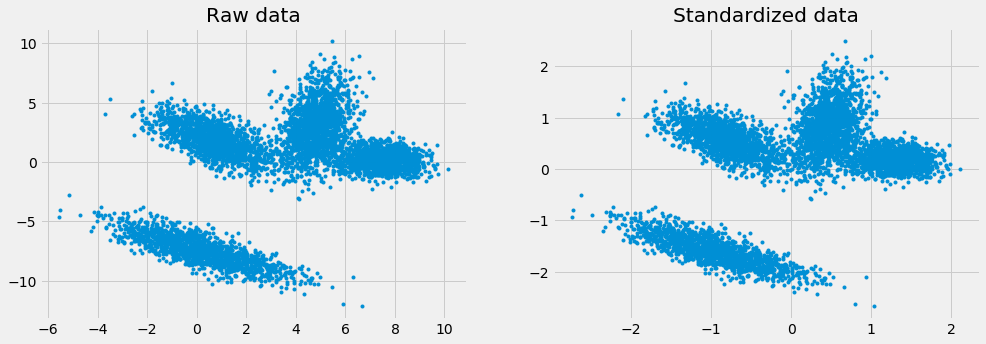

In [18]:
# Plot the raw and standardized data. You might be able to tell that there are 4 groups depending
# on your means.

i = 0
j = 1

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(x_mixed[:,i], x_mixed[:,j], '.')
plt.title('Raw data')

plt.subplot(122)
plt.plot(y_mixed[:,i], y_mixed[:,j], '.')
plt.title('Standardized data')

plt.show()

In [19]:
# Perform PCA
pca_mixed = PCA(n_components=5)
pca_mixed.fit(y_mixed.T)  
mixed_comps = pca_mixed.components_

Text(0.5, 1.0, 'Proportion of variation explained')

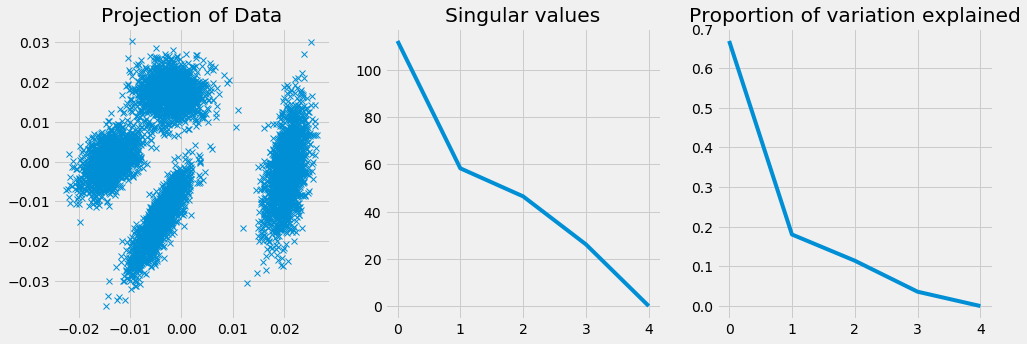

In [20]:
# Plot the projection, singular values, and variance explained. Look at some of the later PCs
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(mixed_comps[0,:], mixed_comps[1,:], 'x')
plt.title('Projection of Data')

plt.subplot(132)
plt.plot(pca_mixed.singular_values_)
plt.title('Singular values')

plt.subplot(133)
plt.plot(pca_mixed.explained_variance_ratio_)
plt.title('Proportion of variation explained')

plt.show()

In [21]:
np.dot(mixed_comps[0,:], mixed_comps[1,:])

-7.199102425303749e-16

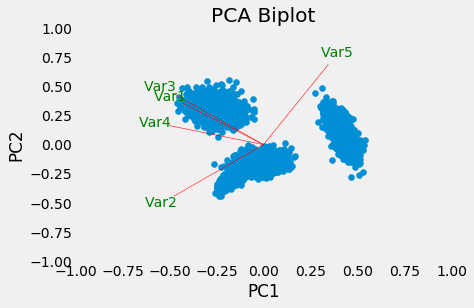

In [22]:
# Now let's look at a useful tool known as a biplot. This shows the projection of our data and also
# draws vectors depicting how our original features are used by our new ones. There might be subtle differences
# between the projection here and what we did previously.

X = np.concatenate((x1, x2, x3, x4))

# code from 
# https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot

scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    
pca = PCA()
x_new = pca.fit_transform(X)

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.title('PCA Biplot')
    plt.grid()
    
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

### Using PCA to detect batch effects

In genetics and genomics, batch effects are one of the biggest problems which sometimes affect our data. PCA is a commonly used to search for these effects, as they typically comprise a dominant source of variation. Here we'll show how batch effects can introduce false signal in real RNA-seq data. These data come from the Geuvadis project and consist of 462 RNA-seq experiments performed on blood samples across 5 different populations. 

In [23]:
# The provided data include reads which have not been corrected for batch, those which have, and the metadata
# detailing which lab performed the sequencing as well as the population of each individual.
# The data have already been normalized and log-transformed.

# Batch effect correction can often be performed using linear models, and that's what I did here. We will
# discuss how to do this when we cover that topic in a couple of weeks. 

expression_uncorrected = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab06/geuv_batch.csv').T
expression_corrected = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab06/geuv_corrected.csv').T
metadata = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab06/geuv_meta.csv').T

In [24]:
# Do PCA on the uncorrected data
uncorrected_means = np.mean(expression_uncorrected, axis = 0)
uncorrected_sds = np.std(expression_uncorrected, axis = 0)

y_uncorrected = (expression_uncorrected - uncorrected_means) / uncorrected_sds

pca_uncorrected = PCA(n_components=100)
pca_uncorrected.fit(y_uncorrected.T)  
uncorrected_comps = pca_uncorrected.components_

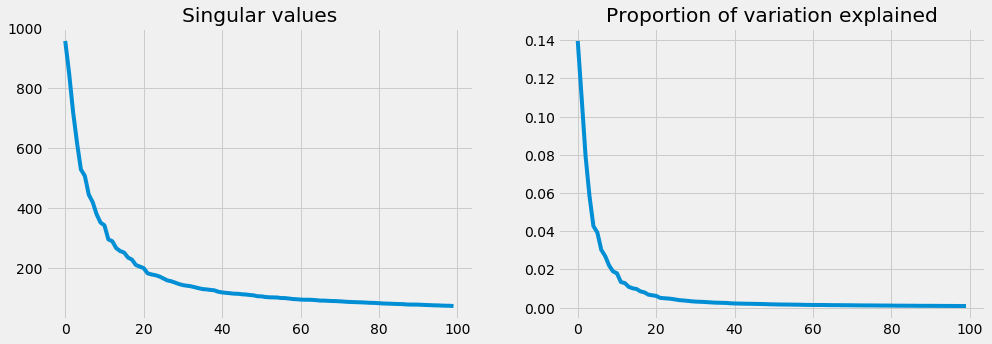

In [25]:
# Compare these plots to the analogous ones from the simulated data.
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(pca_uncorrected.singular_values_)
plt.title('Singular values')

plt.subplot(122)
plt.plot(pca_uncorrected.explained_variance_ratio_)
plt.title('Proportion of variation explained')

plt.show()

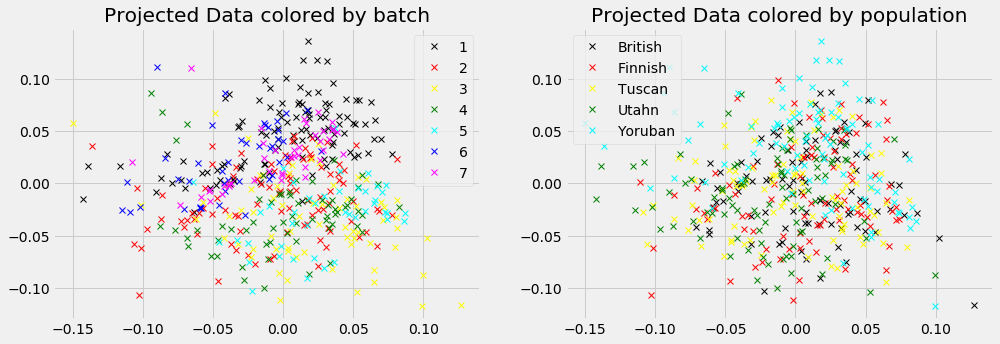

In [26]:
# Now let's look at the projections of our samples. We'll color by both batch and population. What do you observe?
# Do you think there is some clustering by batch?
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(uncorrected_comps[0,metadata.iloc[2,:]==1], uncorrected_comps[1,metadata.iloc[2,:]==1], 'x', c = 'black')
plt.plot(uncorrected_comps[0,metadata.iloc[2,:]==2], uncorrected_comps[1,metadata.iloc[2,:]==2], 'x', c = 'red')
plt.plot(uncorrected_comps[0,metadata.iloc[2,:]==3], uncorrected_comps[1,metadata.iloc[2,:]==3], 'x', c = 'yellow')
plt.plot(uncorrected_comps[0,metadata.iloc[2,:]==4], uncorrected_comps[1,metadata.iloc[2,:]==4], 'x', c = 'green')
plt.plot(uncorrected_comps[0,metadata.iloc[2,:]==5], uncorrected_comps[1,metadata.iloc[2,:]==5], 'x', c = 'cyan')
plt.plot(uncorrected_comps[0,metadata.iloc[2,:]==6], uncorrected_comps[1,metadata.iloc[2,:]==6], 'x', c = 'blue')
plt.plot(uncorrected_comps[0,metadata.iloc[2,:]==7], uncorrected_comps[1,metadata.iloc[2,:]==7], 'x', c = 'magenta')
plt.legend(['1', '2', '3', '4', '5', '6', '7'])
plt.title('Projected Data colored by batch')

plt.subplot(122)
plt.plot(uncorrected_comps[0,metadata.iloc[3,:]=='British'], uncorrected_comps[1,metadata.iloc[3,:]=='British'], 'x', c = 'black')
plt.plot(uncorrected_comps[0,metadata.iloc[3,:]=='Finland'], uncorrected_comps[1,metadata.iloc[3,:]=='Finland'], 'x', c = 'red')
plt.plot(uncorrected_comps[0,metadata.iloc[3,:]=='Tuscan'], uncorrected_comps[1,metadata.iloc[3,:]=='Tuscan'], 'x', c = 'yellow')
plt.plot(uncorrected_comps[0,metadata.iloc[3,:]=='Utah'], uncorrected_comps[1,metadata.iloc[3,:]=='Utah'], 'x', c = 'green')
plt.plot(uncorrected_comps[0,metadata.iloc[3,:]=='Yoruba'], uncorrected_comps[1,metadata.iloc[3,:]=='Yoruba'], 'x', c = 'cyan')


plt.legend(['British', 'Finnish', 'Tuscan', 'Utahn', 'Yoruban'])
plt.title('Projected Data colored by population')

plt.show()

In [27]:
corrected_means = np.mean(expression_corrected, axis = 0)
corrected_sds = np.std(expression_corrected, axis = 0)

y_corrected = (expression_corrected - corrected_means) / corrected_sds

pca_corrected = PCA(n_components=100)
pca_corrected.fit(y_corrected.T)  
corrected_comps = pca_corrected.components_

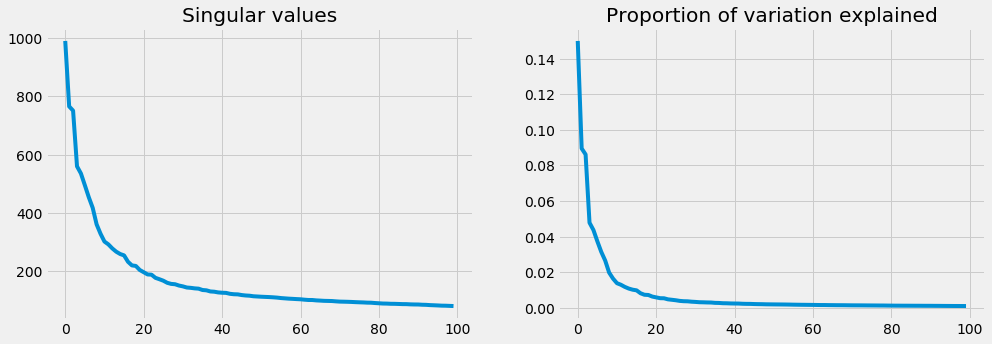

In [28]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(pca_corrected.singular_values_)
plt.title('Singular values')

plt.subplot(122)
plt.plot(pca_corrected.explained_variance_ratio_)
plt.title('Proportion of variation explained')

plt.show()

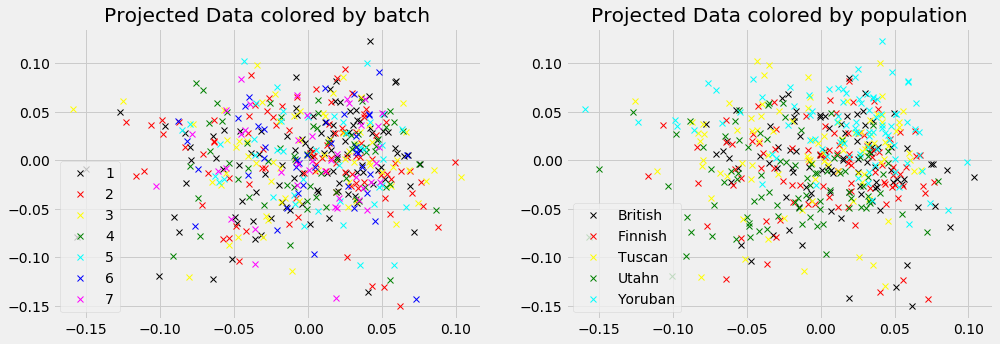

In [29]:
# Now look at the projections of the corrected data, again coloring by batch and population. How does it compare
# to what we had before? Do you think gene expression can be used to predict an individual's population?

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(corrected_comps[0,metadata.iloc[2,:]==1], corrected_comps[1,metadata.iloc[2,:]==1], 'x', c = 'black')
plt.plot(corrected_comps[0,metadata.iloc[2,:]==2], corrected_comps[1,metadata.iloc[2,:]==2], 'x', c = 'red')
plt.plot(corrected_comps[0,metadata.iloc[2,:]==3], corrected_comps[1,metadata.iloc[2,:]==3], 'x', c = 'yellow')
plt.plot(corrected_comps[0,metadata.iloc[2,:]==4], corrected_comps[1,metadata.iloc[2,:]==4], 'x', c = 'green')
plt.plot(corrected_comps[0,metadata.iloc[2,:]==5], corrected_comps[1,metadata.iloc[2,:]==5], 'x', c = 'cyan')
plt.plot(corrected_comps[0,metadata.iloc[2,:]==6], corrected_comps[1,metadata.iloc[2,:]==6], 'x', c = 'blue')
plt.plot(corrected_comps[0,metadata.iloc[2,:]==7], corrected_comps[1,metadata.iloc[2,:]==7], 'x', c = 'magenta')
plt.legend(['1', '2', '3', '4', '5', '6', '7'])
plt.title('Projected Data colored by batch')

plt.subplot(122)
plt.plot(corrected_comps[0,metadata.iloc[3,:]=='British'], corrected_comps[1,metadata.iloc[3,:]=='British'], 'x', c = 'black')
plt.plot(corrected_comps[0,metadata.iloc[3,:]=='Finland'], corrected_comps[1,metadata.iloc[3,:]=='Finland'], 'x', c = 'red')
plt.plot(corrected_comps[0,metadata.iloc[3,:]=='Tuscan'], corrected_comps[1,metadata.iloc[3,:]=='Tuscan'], 'x', c = 'yellow')
plt.plot(corrected_comps[0,metadata.iloc[3,:]=='Utah'], corrected_comps[1,metadata.iloc[3,:]=='Utah'], 'x', c = 'green')
plt.plot(corrected_comps[0,metadata.iloc[3,:]=='Yoruba'], corrected_comps[1,metadata.iloc[3,:]=='Yoruba'], 'x', c = 'cyan')


plt.legend(['British', 'Finnish', 'Tuscan', 'Utahn', 'Yoruban'])
plt.title('Projected Data colored by population')

plt.show()